In [1]:
import os
import sys
import numpy as np
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
def process_data(data_dir):
    # Get list of category folders
    categories = os.listdir(data_dir)
    
    # Initialize lists to store images and labels
    images = []
    labels = []
    
    # Iterate through each category folder
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        if os.path.isdir(category_dir):
            # Get list of image files in the category folder
            image_files = os.listdir(category_dir)
            category_name = category[4:]
            # Append image file paths and labels
            images.extend([os.path.join(category_dir, img) for img in image_files])
            labels.extend([category_name] * len(image_files))
    
    return images, labels

# Specify the path to your dataset folder
data_dir = "256_ObjectCategories"

# Process the data
images, labels = process_data(data_dir)

In [3]:
label_dict = {label: idx for idx, label in enumerate(np.unique(labels))}
labels = [label_dict[class_name] for class_name in labels]

In [4]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [5]:
img_height, img_width = 32, 32

In [6]:
def preprocess_image(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.resnet.preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error processing image: {image_path}, {e}")
        return None

In [7]:
# Preprocess training and validation images
x_train_processed = []
for image in x_train:
    processed_image = preprocess_image(image)
    if processed_image is not None:
        x_train_processed.append(processed_image)
x_train = np.array(x_train_processed)

x_val_processed = []
for image in x_val:
    processed_image = preprocess_image(image)
    if processed_image is not None:
        x_val_processed.append(processed_image)
x_val = np.array(x_val_processed)

In [8]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=257)
y_train = np.array(y_train)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=257)
y_val = np.array(y_val)

In [9]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [10]:
for layer in model.layers:
    layer.trainable = False

In [11]:
x = Flatten()(model.output)
output = Dense(len(label_dict), activation='softmax')(x)

In [12]:
model = Model(inputs=model.input, outputs=output)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

c:\Users\soumy\miniconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
tf.config.run_functions_eagerly(True)
model.fit(x_train, y_train, epochs=15, batch_size=20, validation_data=(x_val, y_val))

Epoch 1/15
1225/1225 [==============================] - 233s 190ms/step - loss: 4.3238 - accuracy: 0.3591 - val_loss: 7.1491 - val_accuracy: 0.2398
Epoch 2/15
1225/1225 [==============================] - 212s 173ms/step - loss: 2.7856 - accuracy: 0.4904 - val_loss: 7.5346 - val_accuracy: 0.2504
Epoch 3/15
1225/1225 [==============================] - 202s 165ms/step - loss: 1.9186 - accuracy: 0.5983 - val_loss: 8.0476 - val_accuracy: 0.2499
Epoch 4/15
1225/1225 [==============================] - 200s 163ms/step - loss: 1.4596 - accuracy: 0.6736 - val_loss: 8.6545 - val_accuracy: 0.2596
Epoch 5/15
1225/1225 [==============================] - 186s 152ms/step - loss: 1.1577 - accuracy: 0.7258 - val_loss: 9.4079 - val_accuracy: 0.2623
Epoch 6/15
1225/1225 [==============================] - 197s 160ms/step - loss: 0.9635 - accuracy: 0.7677 - val_loss: 9.7981 - val_accuracy: 0.2645
Epoch 7/15
1225/1225 [==============================] - 190s 155ms/step - loss: 0.8126 - accuracy: 0.8045 - val_

In [17]:
model.save('uta_datathon.h5')

In [18]:
x_combined = np.concatenate((x_train, x_val), axis=0)
latent_vectors = model.predict(x_combined)

In [26]:
labels = np.array(labels)

labels = pd.DataFrame(labels)

# Convert the latent vectors to a DataFrame
df_latent = pd.DataFrame(latent_vectors)

# Concatenate the labels and latent vectors DataFrames
df = pd.concat([labels, df_latent], axis=1)
# Save the DataFrame to a CSV file
df.to_csv('latent_vectors_with_classes.csv', index=False)

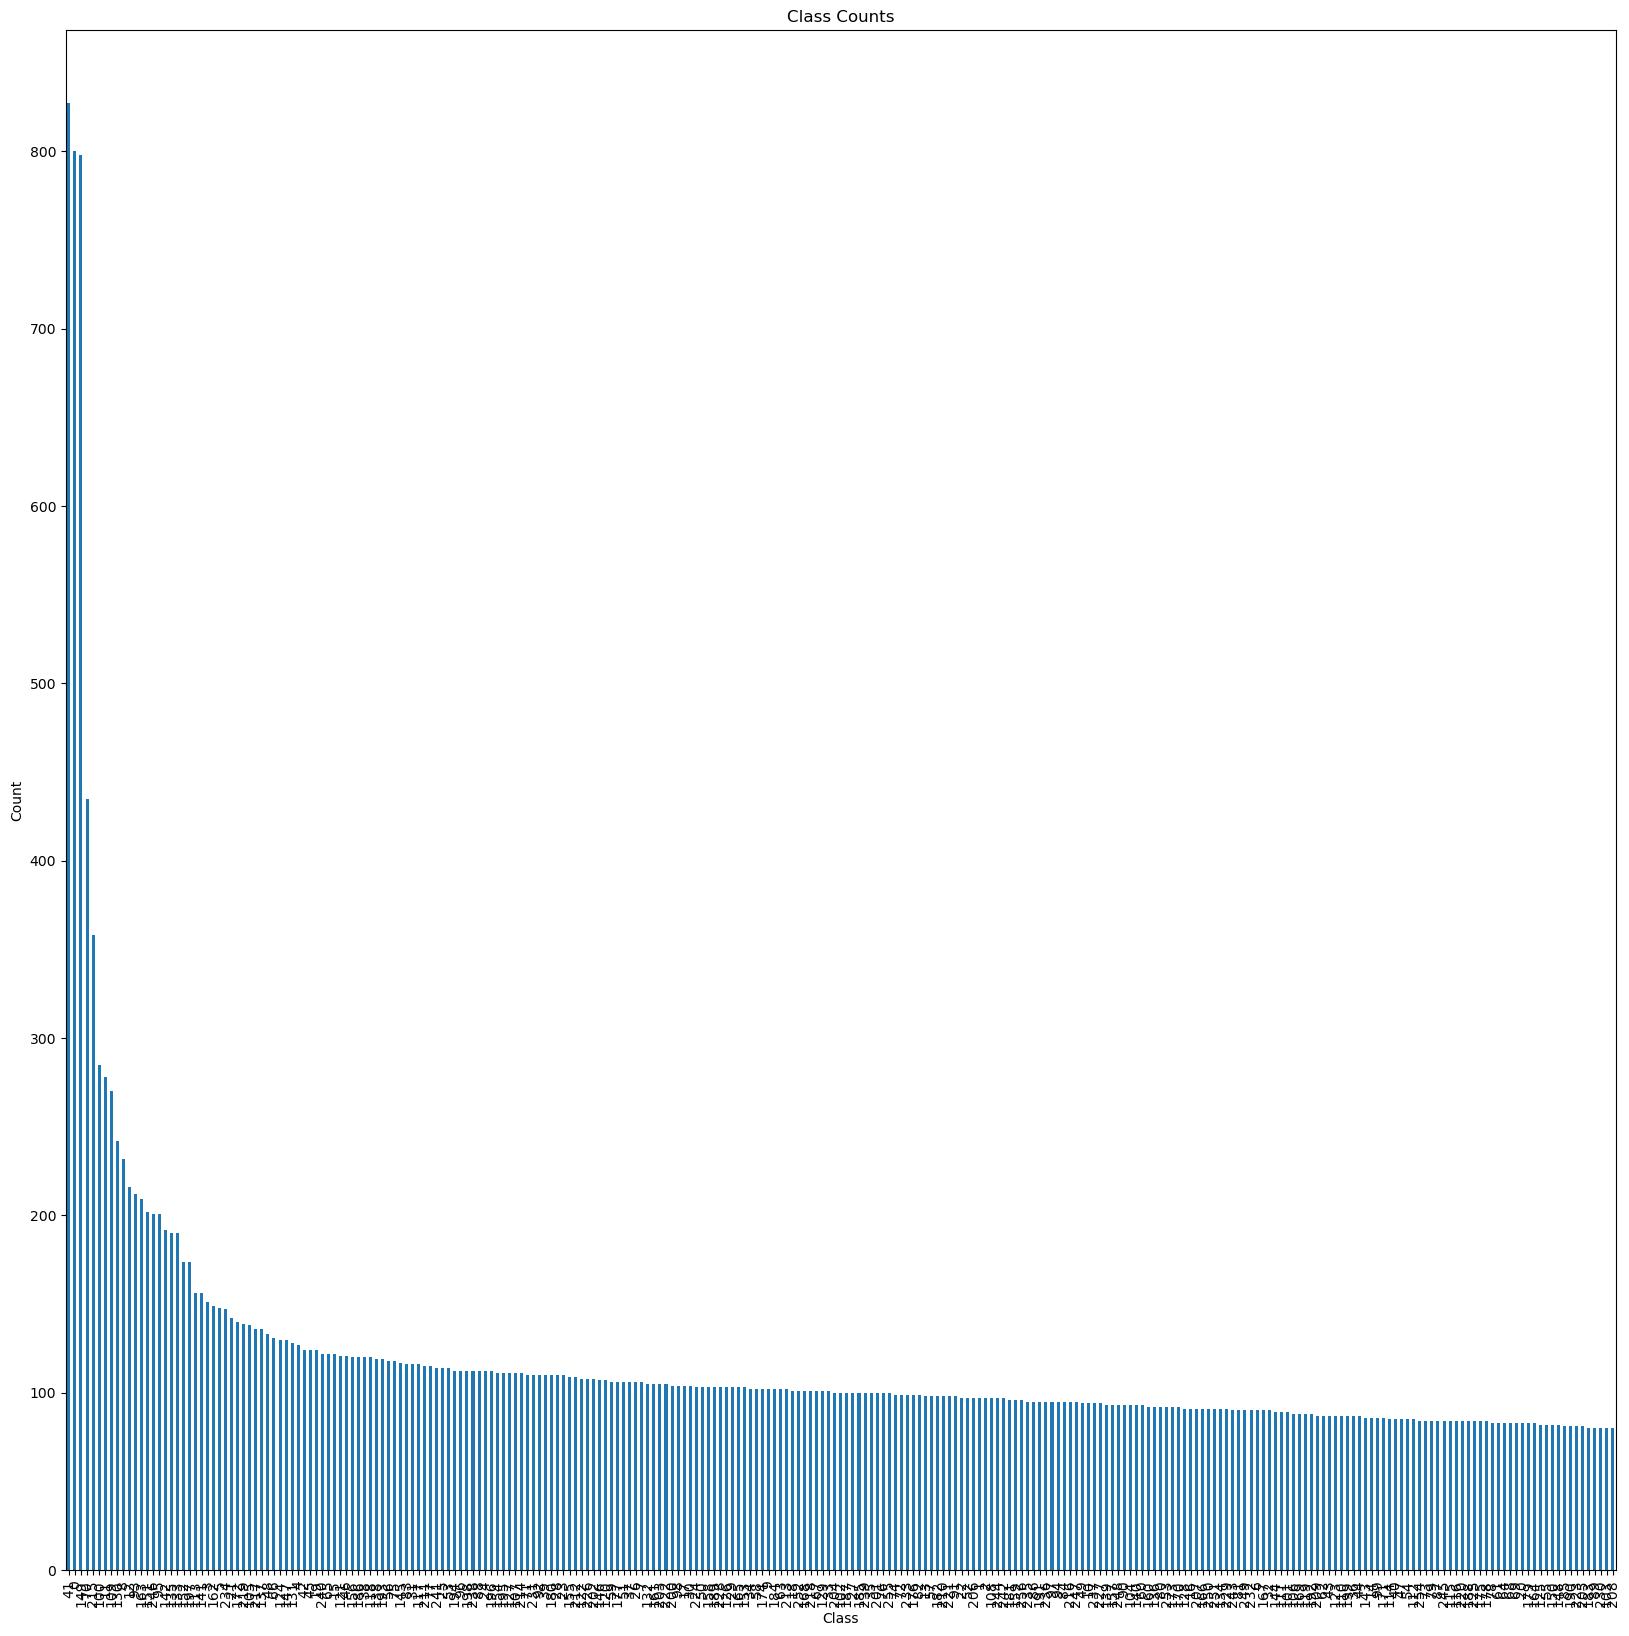

In [27]:
import matplotlib.pyplot as plt
df = pd.read_csv('latent_vectors_with_classes.csv')
df = df.iloc[1:]
# Count the occurrences of each class
class_counts = df[df.columns[0]].value_counts()

# Plot the class counts using a bar plot
plt.figure(figsize=(20, 20))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Counts')
plt.show()

In [28]:
X = df.drop(columns = df.columns[0])  # Features
y = df[df.columns[0]]  # Labels

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
from xgboost import XGBClassifier

In [31]:
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)
y = np.array(y)
senn = SMOTEENN(random_state=42)
X_resampled, y_resampled = senn.fit_resample(X, y)

In [32]:
X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

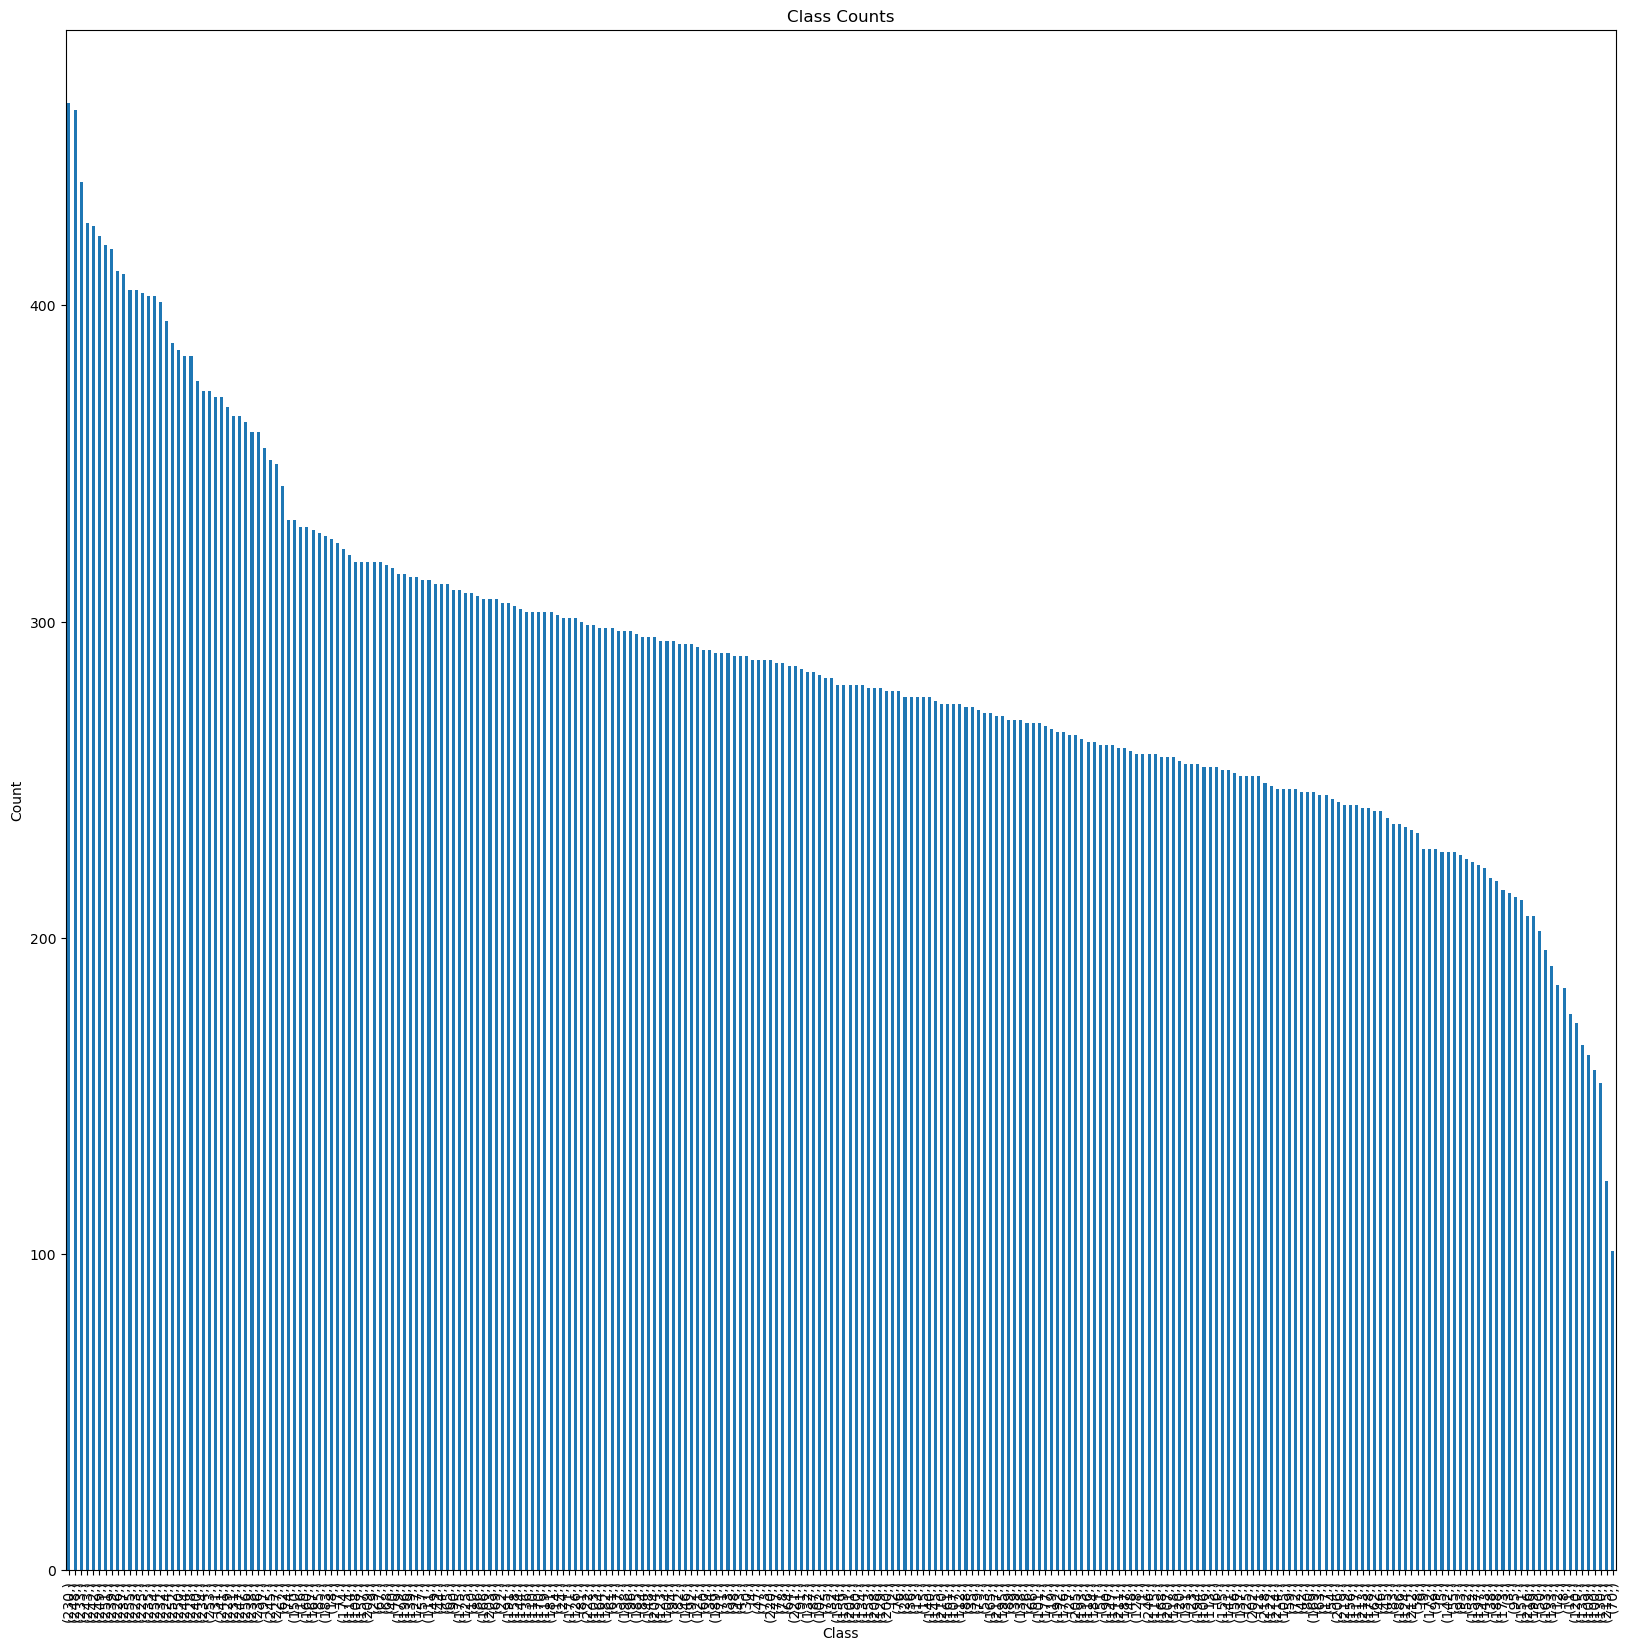

In [33]:
df = pd.DataFrame(y_resampled)
# Count the occurrences of each class
class_counts = df.value_counts()

# Plot the class counts using a bar plot
plt.figure(figsize=(20, 20))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Counts')
plt.show()

In [34]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Initialize the XGBoost classifier
xgb = XGBClassifier()

# Train the classifier on the training data
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [35]:
xgb.save_model("model.json")

In [36]:
y_test = label_encoder.fit_transform(y_test)

# Predict the labels for the testing data
y_pred = xgb.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9576912493120529


In [37]:
# Predict the labels for the testing data
y_pred = xgb.predict(X_train)

# Calculate the accuracy of the classifier

accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0
